# TensorFlow - Word2Vec - Skip Gram Model

---

`Word2Vec`的形式和`Autoencoder`有點像, 同樣是將高維度的輸入資料轉到低維度的空間去, 接著再轉回來.  
因此特地將`Word2Vec`的架構連著`Autoencoder`介紹.  
  
`Word2Vec`常用的類別有`Skip-Gram`跟`CBOW`兩種.  
本篇只針對`Skip-Gram`進行實作, `CBOW`將會在另外的文章中實作.  

# 目標
* 實作`Word2Vec`模型架構中的`Skip-Gram`
* 加深模型中的數據描述方法.

# 目錄

## 1. 載入資料

首先, 我們需要大量的字詞提供給模型做學習.  
我們可以用爬蟲在Google搜尋, 可以使用搜狗實驗室提供的新聞文本.  
而這次我們使用的是國外提供的壓縮後的書本, 目標是讓機器透過這本書學會常用的片語, 當我們輸入某個字後機器會回傳給我們相關的字.  

In [1]:
import requests, os, zipfile, collections, math, random, time
import numpy as np
import tensorflow as tf

from matplotlib import pylab
from sklearn.manifold import TSNE

這邊我們使用自己定義的function, 首先判斷目標目錄是否有檔案.  
如果沒有目錄則建目錄, 沒有檔案則上網抓檔案.  
當檔案確實存在時, 會讀取檔案返回一個放滿了英文單字的list

In [2]:
def maybe_download(file_full_path):
    '''
    Check if the file exists,
    If the file does not exist it will be downloaded.
    Or it will read the file as data.
    return data is a lot of word in a list.
    '''
    # 單獨取出目錄, 由於os.path.join不能接受list, 使用 `* splat` 將list作為單獨參數傳入
    path = os.path.join( *file_full_path.split('/')[:-1] )
    
    # 檢查目錄是否存在, 不存在則先建立目錄
    if not os.path.exists(path):
        os.makedirs(path)
    # 檢查檔案是否存在, 不存在則上網抓取
    if not os.path.exists( file_full_path ):
        request = requests.get('http://mattmahoney.net/dc/text8.zip')
        # 由於抓取的是壓縮檔, 使用 'bw' 用二進位的方式打開
        file = open(file_full_path, 'bw')
        file.write( request.content )
        file.close()

    # 使用 zipfile打開zip檔, 使用with語法可以自動關閉釋放資源
    with zipfile.ZipFile( file_full_path ) as f :
        # f.namelist()[0]會回傳第一筆zip黨內的文件
        # 使用f.read讀取zip檔內的文件, 這邊是讀取第一筆文件
        # 使用tf.compat.as_str可以將bytes的資料轉成utf-8編碼的文字, 這邊是將zip黨內的文件讀取後轉換
        # 將轉換成utf-8的內文用空格分隔, 使之成為一個只含有words的list
        data = tf.compat.as_str( f.read(f.namelist()[0]) ).split()
            
    return data

In [3]:
words = maybe_download('datasets/text8/text8.zip')

## 2. 資料預處理

接著我們再次定義一個function, 將讀出來的文字做成我們需要的樣子.  
首先我們需要這個list裡面出現的都是數字, 因為模型都是只能接收數字的.  
除此之外我們需要兩本字典分別是  字轉數字  跟  數字轉字.  
然而其實有很多字都是出現很少的, 將他們全都丟進unknow裡面, 否則字彙太多會造成模型太大, 這個練習也沒有必要學會所有字, 因為我們的目標只是要相近字而已.  

In [4]:
def build_datasets(words, vocabulary_size=100000):
    '''
    transform the words to labels and make the dictionary which we need.
    return data, count, word_to_label, label_to_word
    '''
    # 第一筆設定為 ['unknow', -1], 之後的資料用Counter從words內找出出現次數最多的前99999筆
    count = [['unknow', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    
    # 透過字典, 將count內儲存的數字一個獨特的編號
    word_to_label={}
    for word, _ in count:
        word_to_label[word] = len(word_to_label)
    
    # 迴圈跑過整個words, 將出現的文字轉換成對應的編號, 沒在字典中的會轉成0
    data = []
    for word in words:
        index = word_to_label[word] if (word in word_to_label) else 0
        data.append(index)
    
    # 將unknow的數量算出
    count[0][1] = (np.array(data)==0).sum()
    # 設定反著的字典, 這兩個字典可以確保互相轉換
    label_to_word = dict(zip(word_to_label.values(), word_to_label.keys()))
    return data, word_to_label, label_to_word

In [5]:
data, word_to_label, label_to_word = build_datasets(words)

## 3. Batch Ganerater

定義批次讀取資料的方法, 這在深度學習中其實是很重要的.  
因為模型複雜的關係, 因此我們很常需要批次的讀取資料, 另外也有批次會比整批訓練來的更好的原因.  
簡單來說就是小批次訓練相對來說不僅訓練起來更好, 也能夠大幅降低設備的需求.  
在語法上只需要注意:  
1. 注意datasets是否有具有迭代器的屬性 (也就是具有 .__iter__() 這個方法)
2. 通常都要使用無窮迴圈, 當迭代器用完全部的元素時要重置狀態重新開始迭代  
滿足這兩個條件的方法都可以設定給模型進行批次訓練.  
而每次我們要傳出甚麼東西則是按照我們想要設計的模型來思考.  
一般來說我們都需要傳出`features`, `labels`兩樣東西.  
讓模型從`features`學習東西, 透過`labels`來計算誤差更新參數.  

以下是因應我們的需求設計的批次方法.  
因為`Skip-Gram`的目標是按照輸入的文字產生上下文向量, 透過上下文向量找出最接近的字.  
因此想法上我們`features`是傳入一個特定的文字, `labels`則是傳入特定文字的上下文.  
讓機器學習看到這個字的時候上下文很可能是什麼.  

同時我們要特別注意輸入給模型的參數.  
最好與別人使用的命名相同, 才不會其他人需要花大量的時間理解參數意義.  
`skip_window`是我要掃描目標文字上下多少個字, 通常不會設太大, 畢竟片語通常也不會有太多字.    
`n_skips`是指掃描了上下的字之後, 總共要回傳幾個字.  
參考了其他人設值, 分別設為掃描上下1個字, 共傳回2個字.  

In [6]:
def batch_generator(data, batch_size, n_skips, skip_window):
    '''
    Scan all of content to yield the batch_size of data.
       
    args.
    skip_window create the span (target-skip_window <- target -> target+skip_window)
    output is random select n_skips data from span
    
    return is tupple of (target_text, nearby_text)
    '''
    #　確保參數的輸入正確
    assert batch_size % n_skips == 0
    assert n_skips <= 2 * skip_window
    
    # 實體化我們要傳出的物件
    batch = np.zeros(batch_size, dtype=np.int32)
    labels = np.zeros((batch_size, 1), dtype=np.int32)
    
    # 初始化, index要從skip_window開始, 取上下文才不會變成負的
    k = 0
    index = skip_window
    # 無窮迴圈產出批次資料
    while True:
        
        # buffer用來暫存index的上下文
        buffer = np.arange(index-skip_window, index+skip_window+1)
        # 但是我們不要index自己, 因此把他刪除
        buffer = np.delete(buffer, len(buffer)//2)
        # 再把buffer打亂, 這樣我們丟進模型的就是亂數的上下文
        np.random.shuffle(buffer)
        
        # 透過迴圈掃buffer, 將目標的index丟進batch, 將上下文丟進labels
        for i, idx in enumerate(buffer):
            # 如果到了我們設定的輸出上限, 就離開, 跑下一個字
            if i>=n_skips :
                break
            batch[k] = data[index]
            labels[k, 0] = data[idx]
            k+=1
        
        # index跑完的時候重置
        if index+skip_window+1 == len(data): index=skip_window
        # index每次+1
        index = (index+1) % len(data)
        
        # k數量達到batch_size時把k重置, 並傳出目前的batch, labels
        if k==batch_size:
            k=0
            yield (batch.copy(), labels.copy())

In [7]:
# 印出前10筆資料看一下
print('data:', [label_to_word[di] for di in data[:10]])

# 呼叫兩次batches看一下是否跟我們想像的一樣
# 這邊我們希望抓取目標的前後各兩筆, 接者從這四筆資料中取兩筆出來
# 看到 as 抓到了後兩筆的 'term' 跟前一筆的 'anarchism' 這代表我們的 batch_generator 正常運作了~~
n_skips, skip_window = 2, 2
batches = batch_generator(data, 8, n_skips, skip_window)
for _ in range(2):
    batch, labels = next(batches)
    print('\nwith num_skips = %d and skip_window = %d:' % (n_skips, skip_window))
    print('    batch:', [label_to_word[bi] for bi in batch])
    print('    labels:', [label_to_word[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 2:
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['originated', 'anarchism', 'as', 'term', 'of', 'as', 'first', 'term']

with num_skips = 2 and skip_window = 2:
    batch: ['abuse', 'abuse', 'first', 'first', 'used', 'used', 'against', 'against']
    labels: ['first', 'used', 'abuse', 'used', 'abuse', 'early', 'early', 'first']


這邊特別注意, 雖然乍看之下`batch`跟`labels`我們都是傳文字出來,  
但是事實上我們兩個shape是不一樣的, 這是因為我們要配合模型的`embedding_lookup`方法.  
不用太在意為什麼這個方法要這樣傳入, 只要知道API是這樣設定就可以了.

## 4. 模型設計

其實像前面那樣設計模型並不是一個好的方法.  
直接宣告變數在交互式的介面中我們容易忘記關閉變數, 但是使用with自動關閉又常常忘記儲存內容.  
而且把東西宣告了整個筆記本也讓人不清楚到底定義的是什麼東西.  
因此更好的方式其實是將整個模型宣告在一個物件中, 在實體化的時候再將模型初始化出來.  
這個寫法也有一個好處, 如果將這個物件程式碼放在.py檔案中, 就可以使用import在其他地方使用.  

In [8]:
class Skip_Gram_model(object):
    def __init__(self, n_vocabulary, n_embedding, label_to_word, lr=1.):
        self.n_vocabulary = n_vocabulary
        self.n_embedding = n_embedding
        self.label_to_word = label_to_word
        
        # 除了傳進來的東西我們設成物件的屬性之外, 把Graph, Session跟model都在一開始就宣告好
        # 由於tensorflow的變數是儲存在Session中, 這代表我們物件沒有消失前變數都不會消失
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.build(lr)
        
    def build(self, lr):
        '''
        build a model use embeddings to look up nearest words.
        return a model based on tensorflow
        '''
        
        # 這裡模型使用自己的圖, 在交互介面中這樣也比較不會讓圖變得很亂
        with self.graph.as_default():
            # 將placeholder都放在同樣的變數名稱下, 圖的起點會很清楚
            with tf.variable_scope('inputs'):
                self.datasets = tf.placeholder(tf.int32, shape=[None], name='datasets')
                self.labels = tf.placeholder(tf.int32, shape=[None, 1], name='labels')
            
            # Skip-Gram的架構下, 我們先用data, lobels訓練模型的準度, 但是我們並不是要用來分類的.  
            # 這種訓練完不使用的做法習慣上稱呼為fake_task
            with tf.variable_scope('fake_task'):
                # 首先是嵌入層, 也就是一個one-hot大表, 所有輸入的資料都在這個表中查找, 然後輸出.
                with tf.variable_scope('embeddings'):
                    self.weights = tf.get_variable('w', 
                            shape=[self.n_vocabulary, self.n_embedding],
                            initializer=tf.random_uniform_initializer(minval=-1, maxval=1))
                    self.biases = tf.get_variable('b', 
                            shape=[self.n_vocabulary], initializer=tf.constant_initializer())
                
                # 將嵌入層進行正規化, 並再給它一個變數名稱, 這個動作對於新手而言在看tensorboard很有幫助
                with tf.variable_scope('norm_embeddings'):
                    self.norm = tf.sqrt(tf.reduce_sum(tf.square(self.weights), 1, keepdims=True))
                    self.normalized_embeddings = self.weights/self.norm
                
                # 將輸入的字經由嵌入層輸出其他的字
                self.embed = tf.nn.embedding_lookup(self.weights, self.datasets)
                
                # 呼叫下方的loss方法建立誤差, 並以此訓練模型
                self.cost = self.loss()
                with tf.variable_scope('training'):
                    self.optimizer = tf.train.AdagradOptimizer(learning_rate=lr)
                    self.train_op = self.optimizer.minimize(self.cost)
            
            # 輸出是將特定文字丟進嵌入層做查詢後乘上標準化後的嵌入層
            with tf.variable_scope('output'):
                self.similarity = tf.matmul(self.embed, tf.transpose(self.normalized_embeddings))
            
            # 初始化所有的變數
            self.init_op = tf.global_variables_initializer()
            self.sess.run(self.init_op)
            
    def loss(self):
        '''
        defining loss function while model in training stage.
        '''
        with tf.variable_scope('loss'):
            # 使用 sampled_softmax_loss 這在類別非常多的時候是好選擇, 但是通常會低估誤差
            n_softmax_sampled = 64
            loss = tf.reduce_mean(
                        tf.nn.sampled_softmax_loss(weights=self.weights,
                                                   biases=self.biases,
                                                   inputs=self.embed,
                                                   labels=self.labels,
                                                   num_sampled=n_softmax_sampled,
                                                   num_classes=self.n_vocabulary),
                        name='loss')
        return loss        
        
    def fit_generator(self, x, y):
        '''
        as inputs processds, updatde the weights in embeddings.
        '''
        feed_dict = {self.datasets:x, self.labels:y}
        _, cost = self.sess.run([self.train_op, self.cost], feed_dict=feed_dict)
        return cost
    
    def nearest_words(self, x, top_nearest):
        '''
        this function calculate the inputs words,
        return the nearest words.
        '''
        similarity = self.sess.run(self.similarity, feed_dict={self.datasets:x})
        
        valid_words = []  # 用來儲存輸入字
        nearests = []     # 用來儲存對於輸入字而言相關性最高的字
        for i in range(x.shape[0]):
            valid_word = self.label_to_word[x[i]]
            valid_words.append(valid_word)
            
            nearest = (-similarity[i, :]).argsort()[1:top_nearest+1]
            nearests.append( list(map(lambda label: self.label_to_word[label], nearest)) )
        return (valid_words, np.array(nearests))
    
#     def evaluate(self, x, y):
#         '''
#         feed dataset and label, return loss of model predicts.
#         '''
#         return self.sess.run(self.cost, feed_dict={self.datasets:x, self.labels:y})
    
    def embedding_matrix(self):
        '''
        return the weights of embeddings.
        '''
        return self.sess.run(self.normalized_embeddings)

In [9]:
text_generator = batch_generator(data, 128, 2, 1)

In [10]:
model = Skip_Gram_model(n_vocabulary=100000,
                        n_embedding=100,
                        label_to_word=label_to_word,
                        lr=1.)

In [11]:
epochs = 50
n_batchs_in_epoch = 5000

for epoch in range(epochs):
    start_time = time.time()
    for _ in range(n_batchs_in_epoch):
        batch, labels = next(text_generator)
        loss = model.fit_generator(x=batch, y=labels)
    
    
    print('Epoch {:2d}/{:2d}: {:2d}s loss = {:7.4f}'.format(epoch+1,epochs, int(time.time()-start_time), loss))

Epoch  1/50: 39s loss =  4.9901
Epoch  2/50: 39s loss =  4.2173
Epoch  3/50: 40s loss =  4.0517
Epoch  4/50: 42s loss =  4.0857
Epoch  5/50: 42s loss =  3.2621
Epoch  6/50: 42s loss =  3.8173
Epoch  7/50: 41s loss =  3.3616
Epoch  8/50: 41s loss =  3.3715
Epoch  9/50: 42s loss =  3.1011
Epoch 10/50: 42s loss =  3.7767
Epoch 11/50: 42s loss =  3.4030
Epoch 12/50: 42s loss =  3.8015
Epoch 13/50: 43s loss =  3.7224
Epoch 14/50: 42s loss =  3.4086
Epoch 15/50: 43s loss =  4.1869
Epoch 16/50: 43s loss =  3.9054
Epoch 17/50: 43s loss =  3.3818
Epoch 18/50: 43s loss =  4.4463
Epoch 19/50: 43s loss =  3.6214
Epoch 20/50: 43s loss =  3.9326
Epoch 21/50: 43s loss =  3.0974
Epoch 22/50: 43s loss =  3.7430
Epoch 23/50: 43s loss =  3.3705
Epoch 24/50: 43s loss =  3.4702
Epoch 25/50: 43s loss =  3.1387
Epoch 26/50: 43s loss =  3.7125
Epoch 27/50: 43s loss =  2.7920
Epoch 28/50: 43s loss =  3.9950
Epoch 29/50: 42s loss =  3.2690
Epoch 30/50: 43s loss =  3.5759
Epoch 31/50: 43s loss =  3.9075
Epoch 32

In [12]:
# 由於我們變數都在model的物件中, 即使我們訓練時忘記寫checkpoint, 也可以現在把圖跟變數存出來
with model.graph.as_default() as g:
    saver = tf.train.Saver(max_to_keep=1)
    summary_writer = tf.summary.FileWriter('logs/Skip-Gram-Model', graph=g)
    saver.save(model.sess, 'logs/Skip-Gram-Model/model-checkpoint')

In [13]:
# 取一些有代表性的字丟給模型, 看看輸出
valid_words_index = np.array([10,20,30,40,50,210,239,392,396])

# 我們可以看到模型學會了一些類別的字, 例如輸入two的時候回傳了8個數字.
# 此外也可以看到模型學到了一些片語, 例如輸入all的時候回傳了of, days等.
valid_words, nearests = model.nearest_words(x=valid_words_index,top_nearest=8)
for i in range(len(valid_words)):
    print("Nearest to '{}': ".format(valid_words[i]),nearests[i])

Nearest to 'two':  ['zero' 'five' 'three' 'four' 'seven' 'eight' 'one' 'six']
Nearest to 'that':  ['arguing' 'note' 'argue' 'suggests' 'claim' 'concluded' 'stating' 'argues']
Nearest to 'his':  ['her' 'followers' 'parents' 'death' 'father' 'their' 'autobiography'
 'colleagues']
Nearest to 'were':  ['are' 'sold' 'they' 'mostly' 'licensed' 'banned' 'manufactured' 'there']
Nearest to 'all':  ['nearly' 'sorts' 'almost' 'days' 'of' 'parts' 'mankind' 'kinds']
Nearest to 'area':  ['metropolitan' 'surface' 'entire' 'boundaries' 'urban' 'region' 'metro'
 'populated']
Nearest to 'east':  ['south' 'west' 'asia' 'indies' 'near' 'southeast' 'timor' 'afc']
Nearest to 'himself':  ['presented' 'advised' 'finds' 'herself' 'persuaded' 'calling' 'mussolini'
 'itself']
Nearest to 'white':  ['red' 'blue' 'purple' 'brown' 'black' 'green' 'marble' 'stripes']


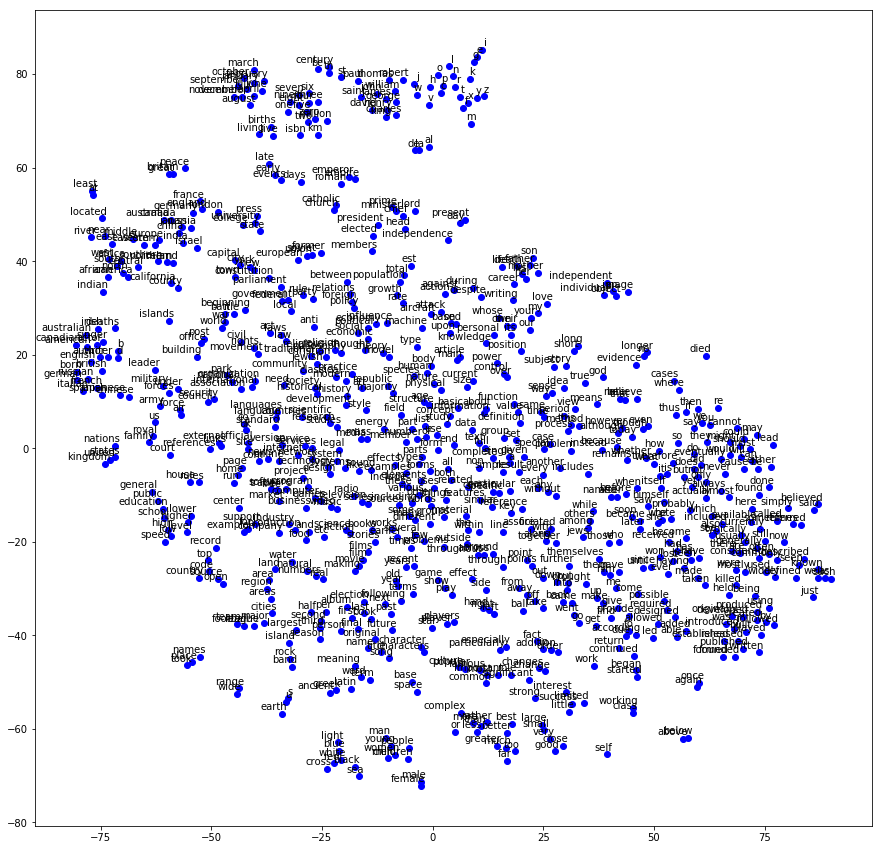

In [15]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, color="blue")
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

visualization_words = 800
# transform embeddings to 2D by t-SNE
embed = model.embedding_matrix()[1:visualization_words+1,:]
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embed = tsne.fit_transform(embed)
# list labels
words = [model.label_to_word[i] for i in range(1, visualization_words+1)]
# plot
plot(two_d_embed,words)